In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
from sklearn.model_selection import train_test_split


In [ ]:
base_dir = '/content/drive/My Drive/Train'
low_dir = os.path.join(base_dir, 'low')
high_dir = os.path.join(base_dir, 'high')

In [ ]:
low_files = [os.path.join(low_dir, file) for file in os.listdir(low_dir)]
high_files = [os.path.join(high_dir, file) for file in os.listdir(high_dir)]

In [ ]:
paired_files = []
for low_file in low_files:
    low_filename = os.path.basename(low_file)
    matching_high_file = os.path.join(high_dir, low_filename)
    if os.path.exists(matching_high_file):
        paired_files.append((low_file, matching_high_file))

In [ ]:
random.seed(42)  # For reproducibility
random.shuffle(paired_files)

In [ ]:
total_samples = len(paired_files)
print(total_samples)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

486


In [ ]:
train_samples = int(total_samples * train_ratio)
val_samples = int(total_samples * val_ratio)

In [ ]:
train_files = paired_files[:train_samples]
val_files = paired_files[train_samples:train_samples + val_samples]
test_files = paired_files[train_samples + val_samples:]


In [ ]:
train_low, train_high = zip(*train_files)
val_low, val_high = zip(*val_files)
test_low, test_high = zip(*test_files)

In [ ]:
print(f"Train low images: {len(train_low)}")
print(f"Train high images: {len(train_high)}")
print(f"Validation low images: {len(val_low)}")
print(f"Validation high images: {len(val_high)}")
print(f"Test low images: {len(test_low)}")
print(f"Test high images: {len(test_high)}")

Train low images: 291
Train high images: 291
Validation low images: 97
Validation high images: 97
Test low images: 98
Test high images: 98


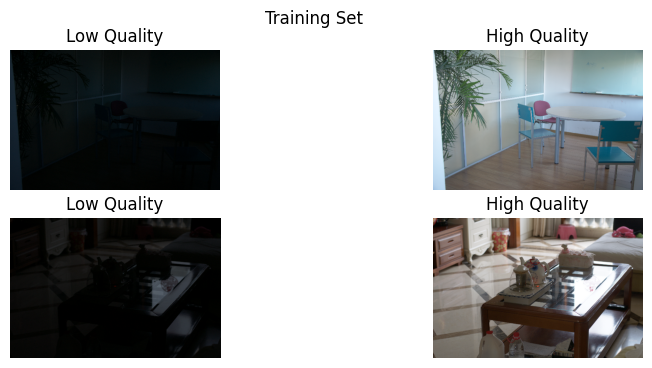

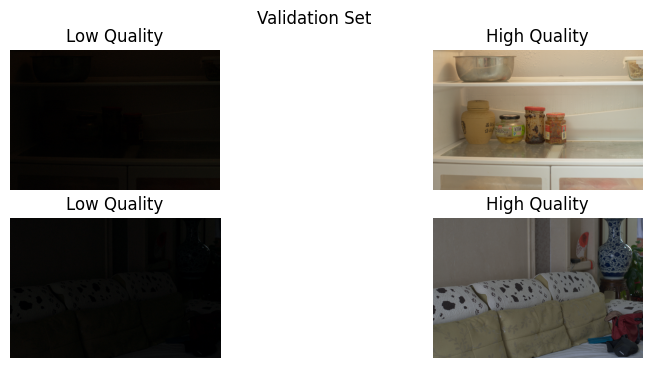

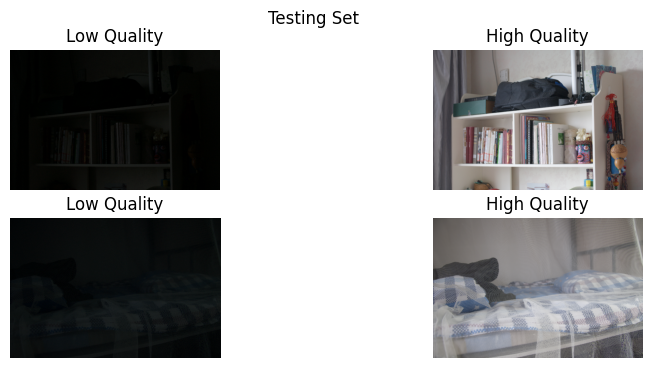

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Function to display images
def display_pairs(low_images, high_images, title):
    plt.figure(figsize=(10, 4))
    for i in range(2):
        plt.subplot(2, 2, i*2 + 1)
        low_img = cv2.imread(low_images[i])
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        plt.imshow(low_img)
        plt.title('Low Quality')
        plt.axis('off')

        plt.subplot(2, 2, i*2 + 2)
        high_img = cv2.imread(high_images[i])
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
        plt.imshow(high_img)
        plt.title('High Quality')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display images for training set
display_pairs(train_low[:10], train_high[:10], title='Training Set')

# Display images for validation set
display_pairs(val_low[:10], val_high[:10], title='Validation Set')

# Display images for testing set
display_pairs(test_low[:10], test_high[:10], title='Testing Set')


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Function to display images
def display_pairs(low_images, high_images, title):
    num_images = len(low_images)
    num_rows = (num_images + 1) // 2  # Calculate number of rows needed
    num_rows=num_images-2
    plt.figure(figsize=(15, 6 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2, i*2 + 1)
        low_img = cv2.imread(low_images[i])
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        plt.imshow(low_img)
        plt.title('Low Quality')
        plt.axis('off')

        plt.subplot(num_rows, 2, i*2 + 2)
        if i < len(high_images):
            high_img = cv2.imread(high_images[i])
            high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
            plt.imshow(high_img)
            plt.title('High Quality')
            plt.axis('off')
        else:
            # Add empty subplot if there are odd number of images
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display all images for training set
display_pairs(train_low, train_high, title='Training Set')

# Display all images for validation set
display_pairs(val_low, val_high, title='Validation Set')

# Display all images for testing set
display_pairs(test_low, test_high, title='Testing Set')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers

def build_dce_net():
    input_img = tf.keras.Input(shape=(256, 256, 3))  # Fixing input shape for consistency

    conv1 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(conv3)

    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])

    conv5 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(int_con1)

    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])

    conv6 = layers.Conv2D(32, (2, 2), strides=(1, 1), activation="relu", padding="same")(int_con2)

    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])

    x_r = layers.Conv2D(3, (2, 2), strides=(1, 1), activation="tanh", padding="same")(int_con3)

    return Model(inputs=input_img, outputs=x_r)

model = build_dce_net()
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mse')


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Define the base directory where the data is stored
base_dir = '/content/drive/My Drive/Train'
low_dir = os.path.join(base_dir, 'low')
high_dir = os.path.join(base_dir, 'high')

# Load the file names and filter out non-image files
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

low_files = [os.path.join(low_dir, file) for file in os.listdir(low_dir) if os.path.splitext(file)[1].lower() in image_extensions]
high_files = [os.path.join(high_dir, file) for file in os.listdir(high_dir) if os.path.splitext(file)[1].lower() in image_extensions]

# Split the dataset into train, val, test
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_low_files, valtest_low_files = train_test_split(low_files, test_size=(val_ratio + test_ratio), random_state=42)
val_low_files, test_low_files = train_test_split(valtest_low_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

train_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in train_low_files]
val_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in val_low_files]
test_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in test_low_files]

def load_and_preprocess_image(file_path):
    image = Image.open(file_path).convert('RGB')  # Ensure the image is in RGB format
    image = image.resize((256, 256))  # Resize to a fixed size if needed
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

def load_images(image_files):
    return [load_and_preprocess_image(file) for file in image_files]

# Load and preprocess the data
train_low_images = load_images(train_low_files)
train_high_images = load_images(train_high_files)
val_low_images = load_images(val_low_files)
val_high_images = load_images(val_high_files)
test_low_images = load_images(test_low_files)
test_high_images = load_images(test_high_files)

# Convert the images to numpy arrays
train_low_images = np.array(train_low_images)
train_high_images = np.array(train_high_images)
val_low_images = np.array(val_low_images)
val_high_images = np.array(val_high_images)

model.load_weights('/content/drive/My Drive/model_weights.h5')

# Assuming `model` is defined somewhere in your code
history = model.fit(
    train_low_images, train_high_images,
    validation_data=(val_low_images, val_high_images),
    epochs=100,  # Adjust epochs as needed
    batch_size=16  # Adjust batch size as needed
)

model_save_path = '/content/drive/My Drive/model_weights.h5'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save model weights
model.save_weights(model_save_path)
print(f'Model weights saved to {model_save_path}')


Epoch 1/100
19/19 [==============================] - 12s 284ms/step - loss: 0.0238 - val_loss: 0.0227
Epoch 2/100
19/19 [==============================] - 4s 213ms/step - loss: 0.0232 - val_loss: 0.0226
Epoch 3/100
19/19 [==============================] - 4s 215ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 4/100
19/19 [==============================] - 4s 223ms/step - loss: 0.0234 - val_loss: 0.0230
Epoch 5/100
19/19 [==============================] - 4s 234ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 6/100
19/19 [==============================] - 4s 220ms/step - loss: 0.0232 - val_loss: 0.0240
Epoch 7/100
19/19 [==============================] - 4s 224ms/step - loss: 0.0233 - val_loss: 0.0224
Epoch 8/100
19/19 [==============================] - 4s 223ms/step - loss: 0.0253 - val_loss: 0.0228
Epoch 9/100
19/19 [==============================] - 5s 240ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 10/100
19/19 [==============================] - 5s 243ms/step - loss: 0.0232 - val_l

In [ ]:
import matplotlib.pyplot as plt

def plot_results(low_images, high_images, predicted_images):
    num_images = min(len(low_images), 10)
    plt.figure(figsize=(15, 6*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(low_images[i])
        plt.title("Low Resolution")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(high_images[i])
        plt.title("High Resolution")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(predicted_images[i])
        plt.title("Predicted")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict high-resolution images
test_low_images_np = np.array(test_low_images)
predicted_images = model.predict(test_low_images_np)

# Plot results
plot_results(test_low_images, test_high_images, predicted_images)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_psnr(high_images, predicted_images):
    psnr_values = []
    for high_image, predicted_image in zip(high_images, predicted_images):
        psnr_value = psnr(high_image, predicted_image, data_range=1)
        psnr_values.append(psnr_value)
    return psnr_values

def plot_results(low_images, high_images, predicted_images, psnr_values):
    num_images = len(low_images)
    num_cols = 10
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 6*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(low_images[i])
        plt.title("Low Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, num_images + i + 1)
        plt.imshow(high_images[i])
        plt.title("High Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, 2 * num_images + i + 1)
        plt.imshow(predicted_images[i])
        plt.title("Predicted\nPSNR: {:.2f}".format(psnr_values[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming test_low_images, test_high_images, and predicted_images are defined
# Predict high-resolution images
# test_low_images_np = np.array(test_low_images)
# predicted_images = model.predict(test_low_images_np)

# Calculate PSNR values
# psnr_values = calculate_psnr(test_high_images, predicted_images)
# avg_psnr = np.mean(psnr_values)

# Plot results with PSNR values
# plot_results(test_low_images, test_high_images, predicted_images, psnr_values)

# Return average PSNR

# Looping over the dataset to plot images
for i in range(len(test_low_images)):
    plot_results([test_low_images[i]], [test_high_images[i]], [predicted_images[i]], [psnr_values[i]])

avg_psnr = np.mean(psnr_values)
print(f'Average PSNR: {avg_psnr:.2f}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr


model.load_weights('/content/drive/My Drive/model_weights.h5')

# predicted_images = model.predict(test_low_images)
test_low_images_np = np.array(test_low_images)
predicted_images = model.predict(test_low_images_np)

def calculate_psnr(high_images, predicted_images):
    psnr_values = []
    for high_image, predicted_image in zip(high_images, predicted_images):
        psnr_value = psnr(high_image, predicted_image, data_range=1)
        psnr_values.append(psnr_value)
    return psnr_values

def plot_results(low_images, high_images, predicted_images, psnr_values):
    num_images = len(low_images)
    num_cols = 10
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 6*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(low_images[i])
        plt.title("Low Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, num_images + i + 1)
        plt.imshow(high_images[i])
        plt.title("High Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, 2 * num_images + i + 1)
        plt.imshow(predicted_images[i])
        plt.title("Predicted\nPSNR: {:.2f}".format(psnr_values[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming test_low_images, test_high_images, and predicted_images are defined
# Predict high-resolution images
# test_low_images_np = np.array(test_low_images)
# predicted_images = model.predict(test_low_images_np)

# Calculate PSNR values
psnr_values = calculate_psnr(test_high_images, predicted_images)
avg_psnr = np.mean(psnr_values)

# Plot results with PSNR values
# plot_results(test_low_images, test_high_images, predicted_images, psnr_values)

# Return average PSNR

# Looping over the dataset to plot images
for i in range(len(test_low_images)):
    plot_results([test_low_images[i]], [test_high_images[i]], [predicted_images[i]], [psnr_values[i]])

avg_psnr = np.mean(psnr_values)
print(f'Average PSNR: {avg_psnr:.2f}')

model.save_weights('/content/drive/My Drive/model_weights.h5')